* [olist dataset] : https://www.kaggle.com/olistbr/brazilian-ecommerce

#Part5. [실습12] 온라인 쇼핑몰 고객 Clustering 분석

## 01. 데이터 소개 및 분석프로세스 수립

## 02. 데이터 탐색 및 전처리

In [ ]:
# !apt-get update -qq
# !apt-get install fonts-nanum* -qq

# from matplotlib import pyplot as plt
# import matplotlib.font_manager as fm

# path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'
# font_name = fm.FontProperties(fname=path, size=10).get_name()

# plt.rc('font', family=font_name)

# fm._rebuild()

In [ ]:
from matplotlib import pyplot as plt
plt.rc('font', family='NanumBarunGothic')

* matplotlib 한글 깨짐 현상 해결
> 셀 실행 후 런타임 재시작 필요

### 0. 데이터 불러오기

In [ ]:
############################################## 00. 필요한 파이썬 라이브러리 불러오기 #####################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter


import time
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.manifold import TSNE
from sklearn.impute import SimpleImputer

from scipy.stats import pearsonr, chi2_contingency
from itertools import combinations
from sklearn.decomposition import PCA

In [ ]:
df_orders = pd.read_csv('/content/drive/MyDrive/강의/실습자료/data/ch14/olist_orders_dataset.csv',sep=',', parse_dates=['order_purchase_timestamp', 'order_estimated_delivery_date', 'order_delivered_customer_date'])
df_customers = pd.read_csv('/content/drive/MyDrive/강의/실습자료/data/ch14/olist_customers_dataset.csv',sep=',')
df_payments = pd.read_csv('/content/drive/MyDrive/강의/실습자료/data/ch14/olist_order_payments_dataset.csv',sep=',')
df_reviews = pd.read_csv('/content/drive/MyDrive/강의/실습자료/data/ch14/olist_order_reviews_dataset.csv',sep=',')
df_geolocation = pd.read_csv("/content/drive/MyDrive/강의/실습자료/data/ch14/olist_geolocation_dataset.csv", sep=',')
df_items = pd.read_csv('/content/drive/MyDrive/강의/실습자료/data/ch14/olist_order_items_dataset.csv',sep=',')
df_products = pd.read_csv('/content/drive/MyDrive/강의/실습자료/data/ch14/olist_products_dataset.csv',sep=',')
product_translations = pd.read_csv('/content/drive/MyDrive/강의/실습자료/data/ch14/product_category_name_translation.csv',sep=',')
df_sellers= pd.read_csv('/content/drive/MyDrive/강의/실습자료/data/ch14/olist_sellers_dataset.csv',sep=',')

### 1. 데이터 전처리

In [ ]:
print(df_customers.columns)

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')


> customer_unique_id

In [ ]:
df_customers.groupby('customer_unique_id').size().value_counts()

1     93099
2      2745
3       203
4        30
5         8
6         6
7         3
17        1
9         1
dtype: int64

#### 고객 기준 데이터 병합

> df_products 와 product_translations 합치기

In [ ]:
df_products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [ ]:
product_translations.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [ ]:
df_products = df_products.merge(product_translations, how = 'left', left_on = 'product_category_name', right_on = 'product_category_name')
print(df_products.columns)

Index(['product_id', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'product_category_name_english'],
      dtype='object')


> df_orders 와 df_customers 합치기

In [ ]:
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [ ]:
df_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [ ]:
df_order_by_customer = pd.merge(df_orders[['customer_id','order_id','order_purchase_timestamp']], df_customers[['customer_id', 'customer_unique_id', 'customer_zip_code_prefix']], how ='inner', on ='customer_id') 
df_order_by_customer = df_order_by_customer.drop_duplicates(keep=False)
print(df_order_by_customer.columns)
print(df_order_by_customer.shape)
print(df_order_by_customer["customer_id"].duplicated().value_counts()) 

Index(['customer_id', 'order_id', 'order_purchase_timestamp',
       'customer_unique_id', 'customer_zip_code_prefix'],
      dtype='object')
(99441, 5)
False    99441
Name: customer_id, dtype: int64


> df_order_by_customer 와 df_payments 합치기 : df_payment_and_order

In [ ]:
df_order_by_customer.head()

,customer_id,order_id,order_purchase_timestamp,customer_unique_id,customer_zip_code_prefix
0,9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,3149
1,b0830fb4747a6c6d20dea0b8c802d7ef,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,47813
2,41ce2a54c0b03bf3443c3d931a367089,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8,75265
3,f88197465ea7920adcdbec7375364d82,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,7c142cf63193a1473d2e66489a9ae977,59296
4,8ab97904e6daea8866dbdbc4fb7aad2c,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,72632f0f9dd73dfee390c9b22eb56dd6,9195


In [ ]:
df_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [ ]:
df_payment_and_order = df_order_by_customer.merge(df_payments, how = 'inner', left_on = 'order_id', right_on = 'order_id')

In [ ]:
df_payment_and_order.head()

,customer_id,order_id,order_purchase_timestamp,customer_unique_id,customer_zip_code_prefix,payment_sequential,payment_type,payment_installments,payment_value
0,9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,3149,1,credit_card,1,18.12
1,9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,3149,3,voucher,1,2.00
2,9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,3149,2,voucher,1,18.59
3,b0830fb4747a6c6d20dea0b8c802d7ef,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,47813,1,boleto,1,141.46
4,41ce2a54c0b03bf3443c3d931a367089,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8,75265,1,credit_card,3,179.12


> df_payment_and_order 를 customer_unique_id, customer_id, order_id, ord_purchase_timestamp 를 기준으로 합을 구하기

In [ ]:
df_payment_by_customer = df_payment_and_order.groupby(['customer_unique_id','customer_id','order_id','order_purchase_timestamp']).sum().reset_index()

In [ ]:
df_payment_by_customer.head()

,customer_unique_id,customer_id,order_id,order_purchase_timestamp,customer_zip_code_prefix,payment_sequential,payment_installments,payment_value
0,0000366f3b9a7992bf8c76cfdf3221e2,fadbb3709178fc513abc1b2670aa1ad2,e22acc9c116caa3f2b7121bbb380d08e,2018-05-10 10:56:27,7787,1,8,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,4cb282e167ae9234755102258dd52ee8,3594e05a005ac4d06a72673270ef9ec9,2018-05-07 11:11:27,6053,1,1,27.19
2,0000f46a3911fa3c0805444483337064,9b3932a6253894a02c1df9d19004239f,b33ec3b699337181488304f362a6b734,2017-03-10 21:05:03,88115,1,8,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,914991f0c02ef0843c0e7010c819d642,41272756ecddd9a9ed0180413cc22fb6,2017-10-12 20:29:41,66812,1,4,43.62
4,0004aac84e0df4da2b147fca70cf8255,47227568b10f5f58a524a75507e6992c,d957021f1127559cd947b62533f484f7,2017-11-14 19:45:42,18040,1,6,196.89


In [ ]:
print(df_payment_by_customer.columns)
print(df_payment_by_customer.shape)
print(df_payment_by_customer["customer_id"].duplicated().value_counts())

Index(['customer_unique_id', 'customer_id', 'order_id',
       'order_purchase_timestamp', 'customer_zip_code_prefix',
       'payment_sequential', 'payment_installments', 'payment_value'],
      dtype='object')
(99440, 8)
False    99440
Name: customer_id, dtype: int64


> df_payment_by_customer 와 df_items 합치기 : df_items_paid

In [ ]:
df_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [ ]:
print(max(df_items['order_item_id']))

21


In [ ]:
###### 코드 작성 부분 시작 ######
# df_payment_by_customer 와 df_items[['order_id','order_item_id', 'product_id', 'price', 'freight_value']] 를 order_id 기준으로 Inner Merge 하기
# df_items_paid = 
###### 코드 작성 부분 마침 ######
print(df_items_paid.shape)
print(df_items_paid["customer_id"].duplicated().value_counts())

(112647, 12)
False    98665
True     13982
Name: customer_id, dtype: int64


> df_items_paid 와 df_products 합치기 : df_products_bought

In [ ]:
df_products_bought = df_items_paid.merge(df_products[['product_id','product_category_name_english']], how = 'inner', left_on = 'product_id', right_on = 'product_id')

print(df_products_bought.shape)
print(df_products_bought.columns)
print(df_products_bought["customer_id"].duplicated().value_counts())

(112647, 13)
Index(['customer_unique_id', 'customer_id', 'order_id',
       'order_purchase_timestamp', 'customer_zip_code_prefix',
       'payment_sequential', 'payment_installments', 'payment_value',
       'order_item_id', 'product_id', 'price', 'freight_value',
       'product_category_name_english'],
      dtype='object')
False    98665
True     13982
Name: customer_id, dtype: int64


> df_products_bought 와 df_reviews 합치기 : df_reviews_by_customer

In [ ]:
df_reviews_by_customer = df_products_bought.merge(df_reviews[['order_id','review_score']], how = 'inner', left_on = 'order_id', right_on = 'order_id')  

print(df_reviews_by_customer.shape)
print(df_reviews_by_customer.columns)
print(df_reviews_by_customer["customer_id"].duplicated().value_counts())


(113319, 14)
Index(['customer_unique_id', 'customer_id', 'order_id',
       'order_purchase_timestamp', 'customer_zip_code_prefix',
       'payment_sequential', 'payment_installments', 'payment_value',
       'order_item_id', 'product_id', 'price', 'freight_value',
       'product_category_name_english', 'review_score'],
      dtype='object')
False    98665
True     14654
Name: customer_id, dtype: int64


> df_reviews_by_customer 를 customer_unique_id 와 customer_id 기준으로 aggregate

In [ ]:
gb_products_bought = df_reviews_by_customer.groupby(['customer_unique_id','customer_id']).agg({
    'order_item_id':'sum',
    'product_category_name_english':'count',
    'price':'sum', 
    'freight_value':'sum',
    'payment_value':'sum', 
    'review_score':'mean', 
    'order_purchase_timestamp':'max', 
    'order_id':'count'}).reset_index()
    
alldata = gb_products_bought.sort_values(by=['product_category_name_english'], ascending=False)

In [ ]:
alldata = alldata.rename(columns={"product_category_name_english": "amount_prod_categories"})

print(alldata.shape)
print(alldata.columns)
print(alldata["customer_id"].duplicated().value_counts())

(98665, 10)
Index(['customer_unique_id', 'customer_id', 'order_item_id',
       'amount_prod_categories', 'price', 'freight_value', 'payment_value',
       'review_score', 'order_purchase_timestamp', 'order_id'],
      dtype='object')
False    98665
Name: customer_id, dtype: int64


In [ ]:
alldata.head()

,customer_unique_id,customer_id,order_item_id,amount_prod_categories,price,freight_value,payment_value,review_score,order_purchase_timestamp,order_id
83916,d97b3cfb22b0d6b25ac9ed4e9c2d481b,be1c4e52bb71e0c54b11a26b8e8d59f2,132,22,1430.16,277.72,18786.90,1.0,2017-10-17 13:06:29,22
26727,4546caea018ad8c692964e3382debd19,fc3d1daec319d62d49bfb5e1f83123e9,231,21,31.80,164.37,4118.31,1.0,2017-07-16 18:19:25,21
75657,c402f431464c72e27330a67f7b94d4fb,be1b70680b9f9694d8c70f41fa3dc92b,210,20,2000.00,202.40,44048.00,1.0,2018-02-22 15:30:41,20
40765,698e1cf81d01a3d389d96145f7fa6df8,bd5d39761aa56689a265d95d8d32b8be,210,20,1974.00,288.80,45256.00,1.0,2017-08-23 09:22:34,20
5935,0f5ac8d5c31de21d2f25e24be15bbffb,10de381f8a8d23fff822753305f71cae,120,15,982.35,243.30,18384.75,5.0,2017-11-23 20:30:52,15


#### 새로운 컬럼 만들기

> 가장 최근 구매일로부터 며칠 전인가 : recency

In [ ]:
latestdate = np.max(alldata['order_purchase_timestamp'])
print(latestdate)

2018-09-03 09:06:57


In [ ]:
alldata['recency'] = alldata['order_purchase_timestamp'].apply(lambda x: (latestdate - x).days)

In [ ]:
alldata['recency']

83916    320
26727    413
75657    192
40765    375
5935     283
        ... 
5967     390
62382    293
33630    242
12165    170
86717    221
Name: recency, Length: 98665, dtype: int64

In [ ]:
alldata= alldata.drop(['order_purchase_timestamp'], axis=1)

In [ ]:
alldata= alldata.drop(['customer_unique_id'], axis=1)
alldata.head()

,customer_id,order_item_id,amount_prod_categories,price,freight_value,payment_value,review_score,order_id,recency
83916,be1c4e52bb71e0c54b11a26b8e8d59f2,132,22,1430.16,277.72,18786.90,1.0,22,320
26727,fc3d1daec319d62d49bfb5e1f83123e9,231,21,31.80,164.37,4118.31,1.0,21,413
75657,be1b70680b9f9694d8c70f41fa3dc92b,210,20,2000.00,202.40,44048.00,1.0,20,192
40765,bd5d39761aa56689a265d95d8d32b8be,210,20,1974.00,288.80,45256.00,1.0,20,375
5935,10de381f8a8d23fff822753305f71cae,120,15,982.35,243.30,18384.75,5.0,15,283


> 총 몇 번 구매하였는가 : order_id -> frequency

In [ ]:
alldata = alldata.rename(columns={"order_id": "frequency"})
alldata.head()

,customer_id,order_item_id,amount_prod_categories,price,freight_value,payment_value,review_score,frequency,recency
83916,be1c4e52bb71e0c54b11a26b8e8d59f2,132,22,1430.16,277.72,18786.90,1.0,22,320
26727,fc3d1daec319d62d49bfb5e1f83123e9,231,21,31.80,164.37,4118.31,1.0,21,413
75657,be1b70680b9f9694d8c70f41fa3dc92b,210,20,2000.00,202.40,44048.00,1.0,20,192
40765,bd5d39761aa56689a265d95d8d32b8be,210,20,1974.00,288.80,45256.00,1.0,20,375
5935,10de381f8a8d23fff822753305f71cae,120,15,982.35,243.30,18384.75,5.0,15,283


In [ ]:
alldata.describe()

,order_item_id,amount_prod_categories,price,freight_value,payment_value,review_score,frequency,recency
count,98665.000000,98665.000000,98665.000000,98665.000000,98665.000000,98665.000000,98665.000000,98665.000000
mean,1.376496,1.131941,138.377845,22.947594,206.945605,4.089770,1.148523,244.811017
std,2.315509,0.567366,211.380815,21.809864,624.185201,1.342549,0.554749,153.386320
min,1.000000,0.000000,0.850000,0.000000,9.590000,1.000000,1.000000,0.000000
25%,1.000000,1.000000,45.950000,13.890000,62.920000,4.000000,1.000000,121.000000
50%,1.000000,1.000000,87.000000,17.240000,110.320000,5.000000,1.000000,226.000000
75%,1.000000,1.000000,149.980000,24.350000,196.600000,5.000000,1.000000,355.000000
max,231.000000,22.000000,13440.000000,1794.960000,109312.640000,5.000000,22.000000,728.000000


#### 판매자 기준 데이터 병합

In [ ]:
df_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [ ]:
df_sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


> df_items 와 df_sellers 를 seller_id 기준으로 병합 -> df_items_sold

In [ ]:
df_items_sold = df_items.merge(df_sellers[['seller_id','seller_zip_code_prefix']], how = 'inner', left_on = 'seller_id', right_on = 'seller_id')
df_items_sold.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'seller_zip_code_prefix'],
      dtype='object')

> df_items_sold 와 df_reviews 를 order_id 기준으로 병합 -> df_items_reviewed

In [ ]:
df_items_reviewed = df_items_sold.merge(df_reviews[['order_id','review_score']], how = 'inner', left_on = 'order_id', right_on = 'order_id')

> df_items_reviewed 와 df_payments 를 order_id 기준으로 병합 -> df_sales

In [ ]:
df_sales = df_items_reviewed.merge(df_payments[['order_id','payment_value']], how = 'inner', left_on = 'order_id', right_on = 'order_id')
df_sales.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'seller_zip_code_prefix', 'review_score', 'payment_value'],
      dtype='object')

> 판매자별 총 판매액과 평균 평점 구하기

In [ ]:
gb_seller = df_sales.groupby(['seller_id']).agg({'payment_value':'sum', 'review_score':'mean'}).reset_index()
gb_seller = gb_seller.rename(columns={"payment_value": "total_revenue"})
print(gb_seller.shape)
print(gb_seller["seller_id"].duplicated().value_counts())

(3095, 3)
False    3095
Name: seller_id, dtype: int64


In [ ]:
gb_seller.head()

,seller_id,total_revenue,review_score
0,0015a82c2db000af6aaaf3ae2ecb0532,2748.06,3.666667
1,001cca7ae9ae17fb1caed9dfb1094831,48349.22,3.883817
2,001e6ad469a905060d959994f1b41e4f,267.94,1.000000
3,002100f778ceb8431b7a1020ff7ab48f,2478.33,4.033898
4,003554e2dce176b5555353e4f3555ac8,139.38,5.000000


### 2. 데이터 정제

#### 중복값

In [ ]:
# 중복된 항목 수 알아보기
print("중복된 항목 수 :", len(alldata[alldata.duplicated()])) 

중복된 항목 수 : 0


#### 결측값

In [ ]:
missing_df = alldata.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')
missing_df

,column_name,missing_count


#### 각 컬럼별 유일한 값의 비율

In [ ]:
i = 0
colnum = []
colname = []
nullpc = []
uniq = []

numrows = len(alldata)

for col in alldata:
    i +=1
    
    uniques = ((len(alldata[col].unique().tolist()))/numrows)*100
    colnum.append(i)
    colname.append(col)
    uniq.append(uniques)


In [ ]:
df_nul = pd.DataFrame({'num':colnum, 'name':colname, '% unique values':uniq})
df_nul = df_nul.sort_values(by='% unique values', ascending=False)
df_nul

,num,name,% unique values
0,1,customer_id,100.000000
5,6,payment_value,30.668423
4,5,freight_value,8.152840
3,4,price,7.909593
8,9,recency,0.622308
1,2,order_item_id,0.023311
2,3,amount_prod_categories,0.019257
7,8,frequency,0.018244
6,7,review_score,0.011149


#### 이상치

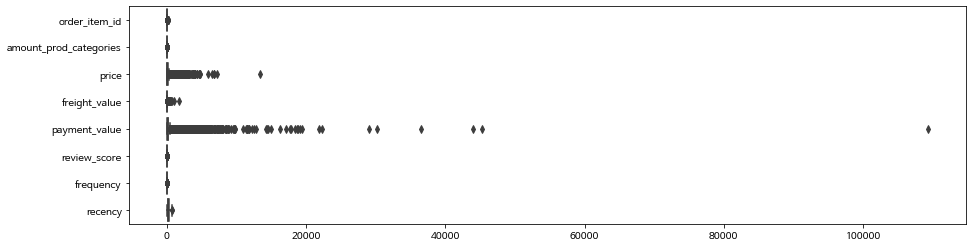

Index(['customer_id', 'order_item_id', 'amount_prod_categories', 'price',
       'freight_value', 'payment_value', 'review_score', 'frequency',
       'recency'],
      dtype='object')


In [ ]:
plt.figure(figsize = (15,4))
sns.boxplot(data = alldata, orient = "h")
plt.show()
print(alldata.columns)

In [ ]:
alldata.shape

(98665, 9)

In [ ]:
alldata1 = alldata[alldata['payment_value'] > 6000]
print (alldata1.shape)

(91, 9)


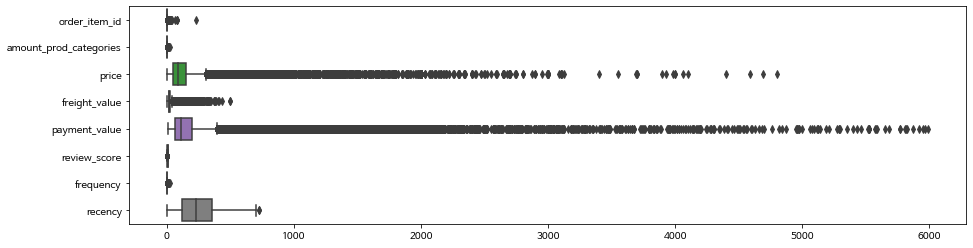

In [ ]:
alldata2 = alldata[alldata['payment_value'] < 6000]
plt.figure(figsize = (15,4))
sns.boxplot(data = alldata2, orient = "h")
plt.show()

In [ ]:
print (alldata2.shape)

(98574, 9)


> 이상치 제거

In [ ]:
def detect_outliers(df, features):
    outlier_indices = []

    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col], 75)
        # Interquartile range (IQR)
        ###### 코드 작성 부분 시작 ######
        # IQR = 
        ###### 코드 작성 부분 마침 ######

        # outlier step
        outlier_step = 8 * IQR

        # 이상치 컬럼 리스트
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)

    outlier_indices = Counter(outlier_indices)        
    return outlier_indices

lof = [ 'price', 'payment_value']
Outliers_to_drop = detect_outliers(alldata, lof)

print(len(Outliers_to_drop))

1895


In [ ]:
alldata = alldata.drop(Outliers_to_drop)

In [ ]:
print(alldata.shape)

(96770, 9)


### 3. 데이터 탐색

#### 판매자 데이터

In [ ]:
gb_seller.head()

,seller_id,total_revenue,review_score
0,0015a82c2db000af6aaaf3ae2ecb0532,2748.06,3.666667
1,001cca7ae9ae17fb1caed9dfb1094831,48349.22,3.883817
2,001e6ad469a905060d959994f1b41e4f,267.94,1.000000
3,002100f778ceb8431b7a1020ff7ab48f,2478.33,4.033898
4,003554e2dce176b5555353e4f3555ac8,139.38,5.000000


In [ ]:
best_noted_sellers = gb_seller[:1000]
best_sellers = best_noted_sellers[['seller_id','review_score','total_revenue']]

> 판매자 평점과 매출 관계

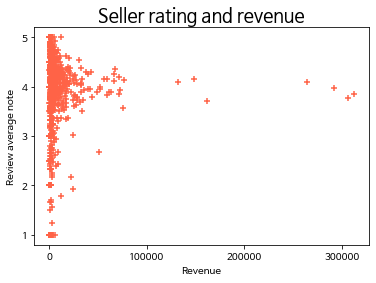

In [ ]:
sellerpop = plt.scatter( y=best_sellers['review_score'], x=best_sellers["total_revenue"],marker = '+', color = 'tomato');
sns.set_context("talk")
plt.xlabel('Revenue')
plt.ylabel('Review average note')
plt.title('Seller rating and revenue')
plt.show()

In [ ]:
customer_satisfaction = alldata.sort_values(by=['review_score'], ascending=False)

In [ ]:
plt.rc('font', family='NanumBarunGothic')

Text(0, 0.5, '누적 횟수')

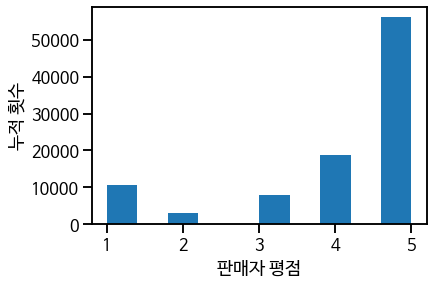

In [ ]:
satisfactiongraph = plt.hist(customer_satisfaction['review_score'])
plt.xlabel('판매자 평점')
plt.ylabel('누적 횟수')

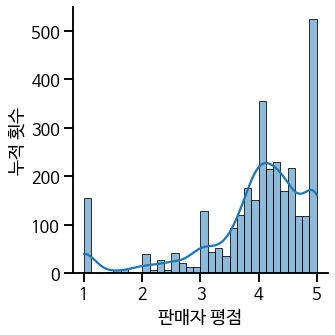

In [ ]:
satisfactiongraph = sns.displot(gb_seller['review_score'],kde=True)
plt.xlabel('판매자 평점')
plt.ylabel('누적 횟수')
plt.show()

#### 제품 구매 선호도

> WordCloud

In [ ]:
missing_df = df_reviews_by_customer.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')
missing_df

,column_name,missing_count
12,product_category_name_english,1636


In [ ]:
df_reviews_by_customer['product_category_name_english'].fillna("None", inplace = True) 

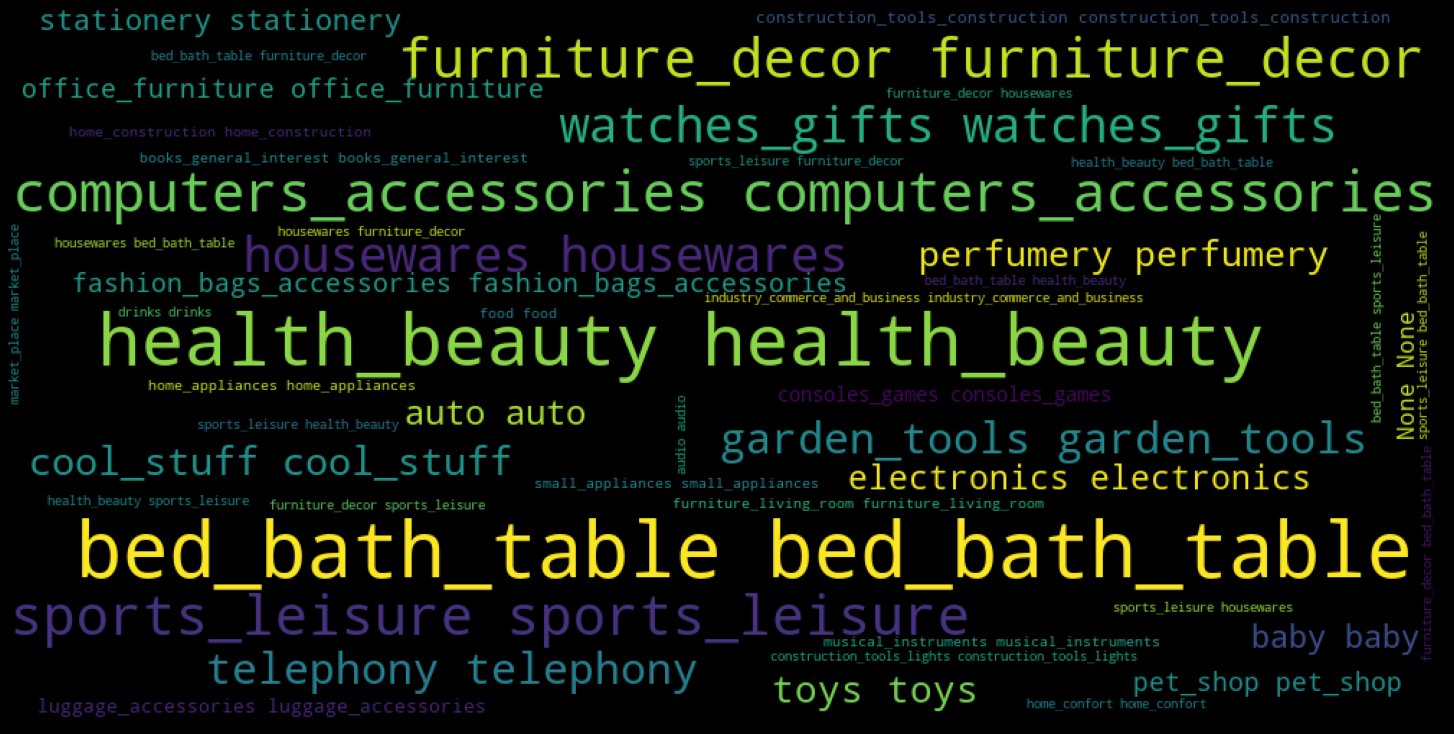

In [ ]:
soup = ' '.join(df_reviews_by_customer['product_category_name_english'])

wordcloud = WordCloud(width=1000, height=500,max_words=50)
wordcloud.generate(soup)
plt.figure(figsize=(20,10),facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [ ]:
# product_category_name_english 별 평균 구하기
product_rew = df_reviews_by_customer.groupby(['product_category_name_english']).mean().reset_index()
# 평점으로 정렬하기
product_rew = product_rew.sort_values(by=['review_score'], ascending=False)

In [ ]:
best_noted_products = product_rew.head(10)

In [ ]:
best_noted_products

,product_category_name_english,customer_zip_code_prefix,payment_sequential,payment_installments,payment_value,order_item_id,price,freight_value,review_score
12,cds_dvds_musicals,44896.214286,1.000000,2.571429,85.673571,1.142857,52.142857,16.070714,4.642857
30,fashion_childrens_clothes,33451.750000,1.000000,1.875000,98.208750,1.000000,71.231250,11.938750,4.500000
9,books_general_interest,39231.645570,1.047016,2.396022,116.988716,1.101266,84.732152,16.628427,4.439421
10,books_imported,24447.633333,1.066667,2.233333,111.698167,1.133333,77.330833,12.830833,4.400000
23,costruction_tools_tools,43637.038835,1.048544,3.048544,204.554078,1.058252,154.407282,19.710874,4.359223
11,books_technical,35150.282528,1.022305,2.107807,92.910223,1.029740,71.185985,16.013011,4.338290
54,luggage_accessories,37388.454212,1.202381,3.522894,171.383965,1.072344,128.598883,27.880247,4.309524
38,food_drink,28122.007143,1.082143,2.110714,98.122964,1.310714,54.537393,16.272607,4.303571
65,small_appliances_home_oven_and_coffee,36801.881579,1.065789,5.631579,674.070000,1.013158,624.285658,36.156053,4.302632
33,fashion_sport,44124.290323,1.000000,2.290323,118.871290,1.258065,69.177419,19.104194,4.258065


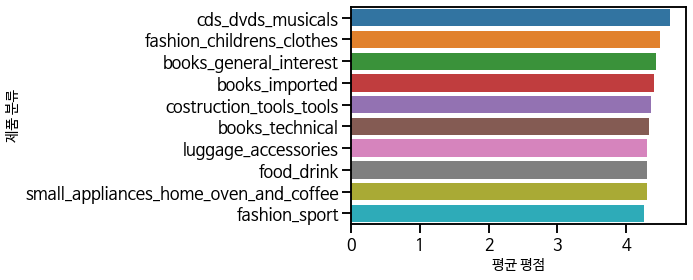

In [ ]:
prodnote_hist = sns.barplot( y=best_noted_products["product_category_name_english"], x=best_noted_products["review_score"]);
sns.set_context("talk")
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(10,8)})
plt.xlabel('평균 평점', fontsize = 14)
plt.ylabel('제품 분류', fontsize = 14)
plt.show()

In [ ]:
# product_category_name_english 별 합계 구하기
prodcat = df_reviews_by_customer.groupby(['product_category_name_english']).sum().reset_index() 
prodcat = prodcat[prodcat['product_category_name_english'] != 'None']
# order_item_id 기준으로 정렬하기
prodcat = prodcat.sort_values(by=['order_item_id'], ascending=False)
prodcat.head()

,product_category_name_english,customer_zip_code_prefix,payment_sequential,payment_installments,payment_value,order_item_id,price,freight_value,review_score
8,bed_bath_table,374793596,14080,42741,1744205.53,13913,1051085.50,207310.74,43636
40,furniture_decor,311959910,9737,27681,1444383.69,11664,736682.46,174420.67,32716
44,health_beauty,345872367,10554,30329,1663076.30,11135,1263102.57,183488.76,40118
66,sports_leisure,319983379,9540,22579,1400270.11,10002,993684.51,169692.51,35616
16,computers_accessories,295317493,8566,18458,1599574.66,9960,919721.44,148442.64,30953


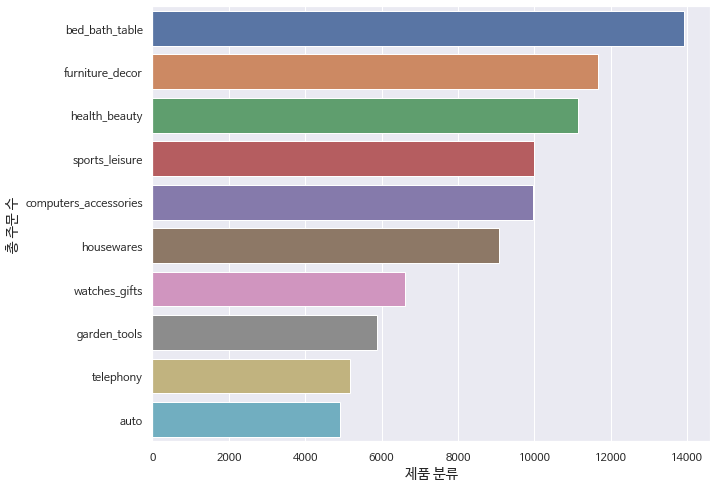

In [ ]:

plt.rc('font', family='NanumBarunGothic')
prodcat0 = prodcat[:10]
catorderhist = sns.barplot( y=prodcat0["product_category_name_english"], x=prodcat0["order_item_id"] );
sns.set_context("talk")
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(10,8)})
plt.xlabel('제품 분류', fontsize = 14)
plt.ylabel('총 주문 수', fontsize = 14)
plt.show()

In [ ]:
prodcat = prodcat.sort_values(by=['payment_value'], ascending=False)
prodcat1 = prodcat[:10]

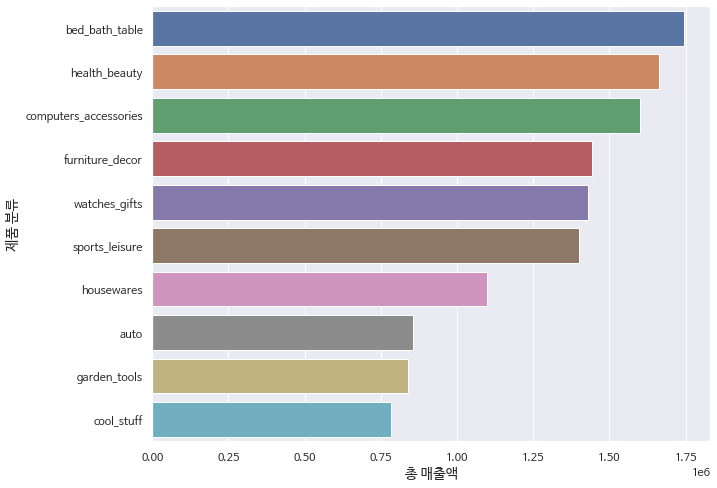

In [ ]:
plt.rc('font', family='NanumBarunGothic')
cat_revenue_hist = sns.barplot( y=prodcat1["product_category_name_english"], x=prodcat1["payment_value"] );
sns.set(rc={'figure.figsize':(10,15)})
plt.xlabel('총 매출액', fontsize = 14)
plt.ylabel('제품 분류', fontsize = 14)
plt.show()

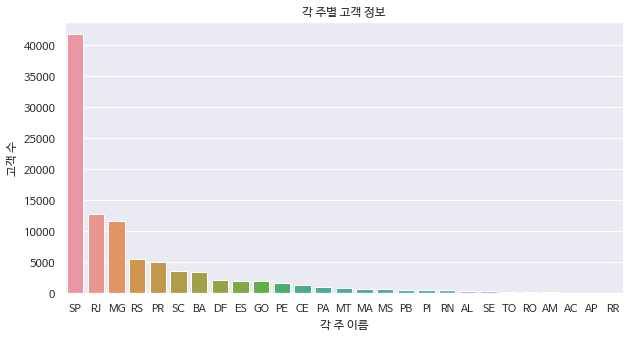

In [ ]:
plt.rc('font', family='NanumBarunGothic')
plt.figure(figsize=(10,5))
plt.title('각 주별 고객 정보')
plt.ylabel('고객 수')
plt.xlabel('각 주 이름')
sns.barplot(x=df_customers['customer_state'].value_counts().index,y=df_customers['customer_state'].value_counts().values)

## 3. RFM 분석하기

* Recency: 고객이 최근에 구입을 했는가? 
* Frequency: 고객이 얼마나 빈번하게 상품을 구입했는가?
* Monetary: 고객이 구입했던 총 금액은 얼마인가?

In [ ]:
transaction_data = alldata[['customer_id','frequency','recency','payment_value']]
print(transaction_data.shape)
transaction_data.head()

(96770, 4)


,customer_id,frequency,recency,payment_value
38753,b4afeb58ac51bc903c5362286c6a5cfe,8,288,992.96
27611,08a0a61f98f22952682f7e463ef2d43e,6,170,1252.08
80902,cc3f0f9c25480b83c834bf8af1435a29,6,9,426.60
5718,620732fed5579e0bdfdddee02aad4c54,6,692,774.18
25363,109f80397e4897bbcf56313c25850332,6,112,1157.04


In [ ]:
df_RFM = transaction_data.rename(columns={"payment_value": "monetary_value"})
df_RFM = df_RFM.reset_index()

In [ ]:
df_RFM.head()

,index,customer_id,frequency,recency,monetary_value
0,38753,b4afeb58ac51bc903c5362286c6a5cfe,8,288,992.96
1,27611,08a0a61f98f22952682f7e463ef2d43e,6,170,1252.08
2,80902,cc3f0f9c25480b83c834bf8af1435a29,6,9,426.60
3,5718,620732fed5579e0bdfdddee02aad4c54,6,692,774.18
4,25363,109f80397e4897bbcf56313c25850332,6,112,1157.04



    frequency: # of days in which a customer made a repeat purchase
    T: customer's age in days
    recency: customer's age in days at time of most recent purchase
    monetary_value: sum of a customer's purchases



In [ ]:
df_RFM = df_RFM[df_RFM['frequency']>0]
df_RFM.describe()

,index,frequency,recency,monetary_value
count,96770.000000,96770.000000,96770.000000,96770.000000
mean,49337.110912,1.118373,244.800434,162.523740
std,28476.524071,0.409977,153.357231,168.489635
min,0.000000,1.000000,0.000000,9.590000
25%,24680.250000,1.000000,121.000000,62.250000
50%,49337.500000,1.000000,226.000000,107.780000
75%,73997.750000,1.000000,355.000000,189.190000
max,98664.000000,8.000000,728.000000,1265.480000


In [ ]:
quintiles = df_RFM[['recency', 'frequency', 'monetary_value']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

{'frequency': {0.2: 1.0, 0.4: 1.0, 0.6: 1.0, 0.8: 1.0},
 'monetary_value': {0.2: 54.53,
  0.4: 86.74,
  0.6: 133.85,
  0.8: 218.21000000000004},
 'recency': {0.2: 100.0, 0.4: 184.0, 0.6: 275.0, 0.8: 390.0}}

In [ ]:
def r_score(x):
    if x <= quintiles['recency'][.2]:
        return 5
    elif x <= quintiles['recency'][.4]:
        return 4
    elif x <= quintiles['recency'][.6]:
        return 3
    elif x <= quintiles['recency'][.8]:
        return 2
    else:
        return 1
    
def fm_score(x, c):
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5    

In [ ]:
df_RFM['R'] = df_RFM['recency'].apply(lambda x: r_score(x))
df_RFM['F'] = df_RFM['frequency'].apply(lambda x: fm_score(x, 'frequency'))
df_RFM['M'] = df_RFM['monetary_value'].apply(lambda x: fm_score(x, 'monetary_value'))

In [ ]:
df_RFM['RFM Score'] = df_RFM['R'].map(str) + df_RFM['F'].map(str) + df_RFM['M'].map(str)
df_RFM.head()

,index,customer_id,frequency,recency,monetary_value,R,F,M,RFM Score
0,38753,b4afeb58ac51bc903c5362286c6a5cfe,8,288,992.96,2,5,5,255
1,27611,08a0a61f98f22952682f7e463ef2d43e,6,170,1252.08,4,5,5,455
2,80902,cc3f0f9c25480b83c834bf8af1435a29,6,9,426.60,5,5,5,555
3,5718,620732fed5579e0bdfdddee02aad4c54,6,692,774.18,1,5,5,155
4,25363,109f80397e4897bbcf56313c25850332,6,112,1157.04,4,5,5,455


In [ ]:
segt_map = {
    r'[1-2][1-2]': '최근구매없음/구매횟수적음',
    r'[1-2][3-4]': '최근구매없음/구매횟수보통',
    r'[1-2]5': '최근구매없음/구매횟수많음',
    r'3[1-2]': '비교적최근구매함/구매횟수적음',
    r'33': '비교적최근구매함/구매횟수보통',
    r'[3-4][4-5]': '최근구매함/구매횟수많음',
    r'41': '최근구매함/구매횟수적음',
    r'51': '방금전구매함/구매횟수적음',
    r'[4-5][2-3]': '방금전구매함/구매횟수보통/프로모션대상',
    r'5[4-5]': '방금전구매함/구매횟수많음'
}

df_RFM['Segment'] = df_RFM['R'].map(str) + df_RFM['F'].map(str)
df_RFM['Segment'] = df_RFM['Segment'].replace(segt_map, regex=True)
df_RFM.head()



,index,customer_id,frequency,recency,monetary_value,R,F,M,RFM Score,Segment
0,38753,b4afeb58ac51bc903c5362286c6a5cfe,8,288,992.96,2,5,5,255,최근구매없음/구매횟수많음
1,27611,08a0a61f98f22952682f7e463ef2d43e,6,170,1252.08,4,5,5,455,최근구매함/구매횟수많음
2,80902,cc3f0f9c25480b83c834bf8af1435a29,6,9,426.60,5,5,5,555,방금전구매함/구매횟수많음
3,5718,620732fed5579e0bdfdddee02aad4c54,6,692,774.18,1,5,5,155,최근구매없음/구매횟수많음
4,25363,109f80397e4897bbcf56313c25850332,6,112,1157.04,4,5,5,455,최근구매함/구매횟수많음


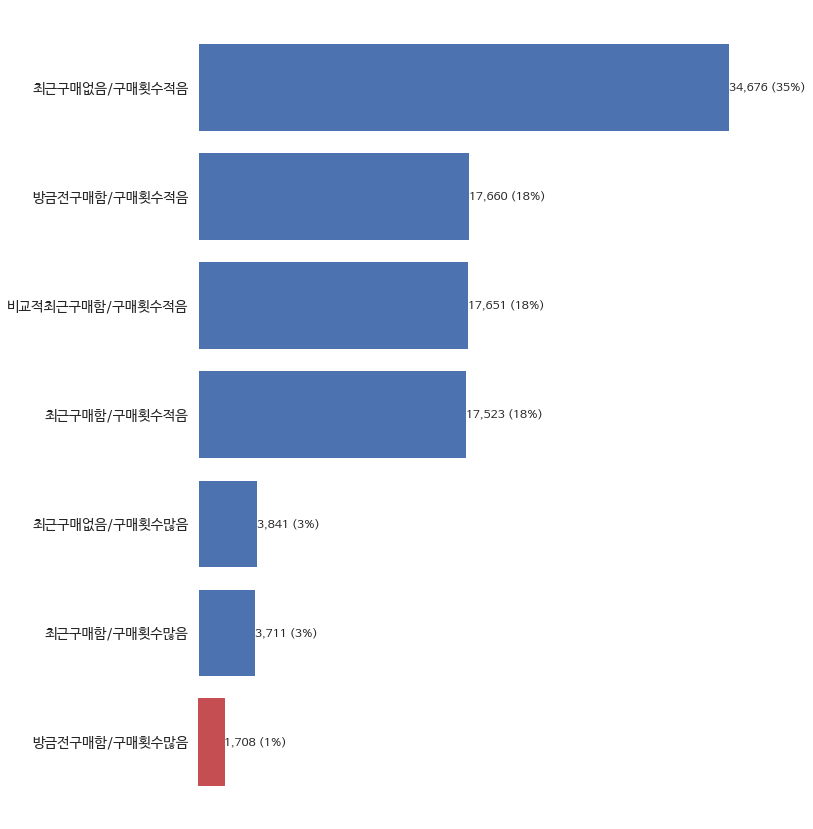

In [ ]:
segments_counts = df_RFM['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='b')

ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)

ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index,  fontsize = 14)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['방금전구매함/구매횟수보통/프로모션대상', '방금전구매함/구매횟수많음']:
            bar.set_color('r')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )
sns.set(rc={'figure.figsize':(5,10)})
plt.show()

In [ ]:
!pip install pyclustering

In [ ]:
!pip install cuml

  Using cached cuml-0.6.1.post1.tar.gz (1.1 kB)
  ERROR: Failed building wheel for cuml
  Running setup.py clean for cuml
Failed to build cuml
    Running setup.py install for cuml ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-3elxoeaw/cuml_909046cab8c74edb885993da87dae921/setup.py'"'"'; __file__='"'"'/tmp/pip-install-3elxoeaw/cuml_909046cab8c74edb885993da87dae921/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-3jd9cp3f/install-record.txt --single-version-externally-managed --compile --install-headers /usr/local/include/python3.7/cuml Check the logs for full command output.


In [ ]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

## 4. Unsupervised Segmentation

### K-Means Clustering


In [ ]:
alldata.columns

Index(['customer_id', 'order_item_id', 'amount_prod_categories', 'price',
       'freight_value', 'payment_value', 'review_score', 'frequency',
       'recency'],
      dtype='object')

#### 1) Feature Selection

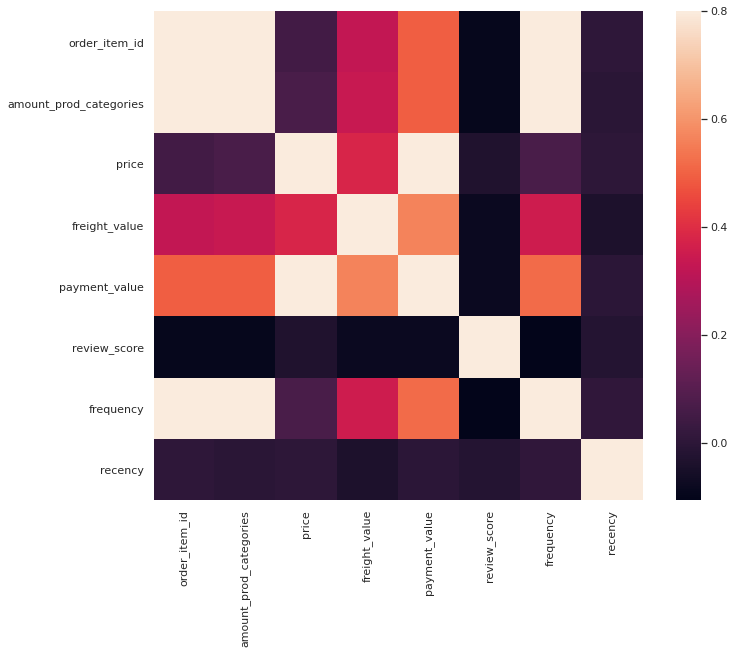

In [ ]:
sns.set(style="white")
corrmat = alldata.corr()

f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [ ]:
num_feat = alldata.select_dtypes('number').columns.values
comb_num_feat = np.array(list(combinations(num_feat, 2)))
corr_num_feat = np.array([])
for comb in comb_num_feat:
    corr = pearsonr(alldata[comb[0]], alldata[comb[1]])[0]
    corr_num_feat = np.append(corr_num_feat, corr)

In [ ]:
high_corr_num = comb_num_feat[np.abs(corr_num_feat) >= 0.95]
high_corr_num

array([['order_item_id', 'frequency']], dtype='<U22')

In [ ]:
grouping_variables = ['amount_prod_categories','payment_value', 'freight_value', 'review_score', 'recency'] 

In [ ]:
df_reduced = alldata[grouping_variables]

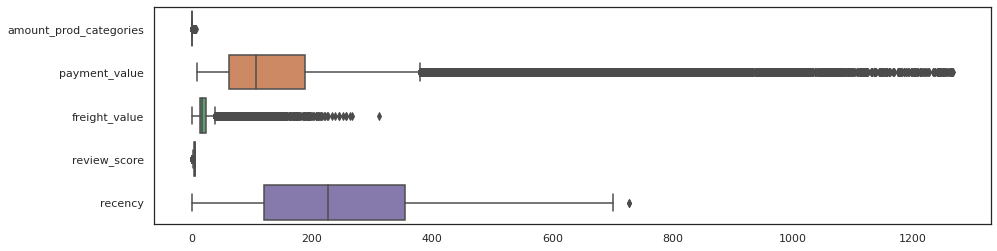

In [ ]:
plt.figure(figsize = (15,4))
sns.boxplot(data = df_reduced, orient = "h")
plt.show()

#### 2) Scailing

In [ ]:
X = df_reduced.values
X_scaled = scale(X)
print('X meanX',np.mean(X_scaled),',X standard deviation:',np.std(X_scaled))

X meanX 8.399926523814763e-18 ,X standard deviation: 1.0


> 결측값을 평균값으로 Imputation

In [ ]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(X_scaled)
X_scaled = imputer.transform(X_scaled)

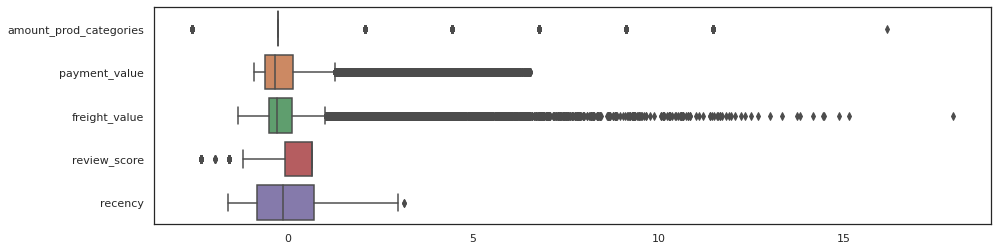

In [ ]:
scaled_dataframe = pd.DataFrame( X_scaled, columns = df_reduced.columns )
plt.figure(figsize = (15,4))
sns.boxplot(data = scaled_dataframe, orient = "h")
plt.show()

#### 3) 데이터 준비

In [ ]:
train_size = int(len(X) * 0.98)
X_train, X_test = X[0:train_size], X[train_size:len(X)]

print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(X_train)))
print('Testing Observations: %d' % (len(X_test)))

Observations: 96770
Training Observations: 94834
Testing Observations: 1936


#### 4) Hyperparameters Optimization 

##### Elbow Method

In [ ]:
from sklearn.cluster import KMeans
wcss_all = []
allgaps = []

def optimalK(data, nrefs=3, maxClusters=10):
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):
        wcss = np.zeros(nrefs)

        # 랜덤 샘플링으로 형태가 같은 데이터를 만들고 주어진 n에 대하여 클러스터링
        for i in range(nrefs):
            randomReference = np.random.random_sample(size=data.shape)
            kmeans = KMeans(k)
            kmeans.fit(randomReference)
            
            w = kmeans.inertia_
            wcss[i] = w

        # 분석 대상 데이터로 주어진 n에 대하여 클러스터링
        kmeans = KMeans(n_clusters = k, init="k-means++", random_state=10)
        kmeans.fit(data)
        
        origin_w = kmeans.inertia_

        # 랜덤 샘플링 데이터에 대한 wcss 의 평균과 분석 대상 데이터의 Inertia value 의 차이를 gap 으로 저장
        gap = np.log(np.mean(wcss)) - np.log(origin_w)
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap, 'origin_w':round(origin_w/100000000,1)}, ignore_index=True)
        allgaps.append(gap)
        wcss_all.append(origin_w)

    print(resultsdf)        
    return(resultsdf)

In [ ]:
resultsdf = optimalK(X_train, nrefs=3, maxClusters=10)

   clusterCount        gap  origin_w
0           1.0 -11.741162      49.7
1           2.0 -11.439771      31.2
2           3.0 -10.938045      16.9
3           4.0 -10.810879      13.4
4           5.0 -10.623685      10.2
5           6.0 -10.545795       8.8
6           7.0 -10.476500       7.7
7           8.0 -10.414790       6.8
8           9.0 -10.370634       6.1


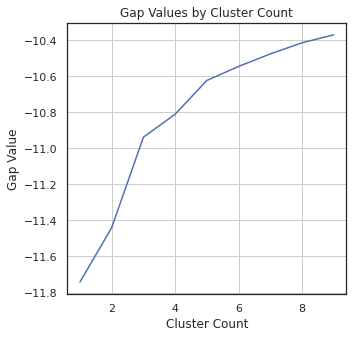

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(range(1,10), allgaps)
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()

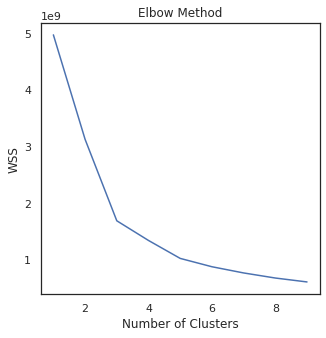

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(range(1, 10), wcss_all)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WSS')
plt.show()

1.5 Optimal number of cluster, based on Silhouette coefficients estimation

k=4

In [ ]:
kmeans = KMeans(n_clusters=4, init="random", random_state=10)
clusts_train = kmeans.fit_predict(X_train)

In [ ]:
clusts_test = np.zeros(len(X_test))
clusts_test = clusts_test + 42
clusts_test

array([42., 42., 42., ..., 42., 42., 42.])

In [ ]:
clust = np.concatenate((clusts_train, clusts_test), axis=None)
print(clusts_train.shape, clusts_test.shape ,clust.shape)

(94834,) (1936,) (96770,)


In [ ]:
df_train = pd.DataFrame.from_records(X_train)
df_test = pd.DataFrame.from_records(X_test)

In [ ]:
df_clustered = pd.concat([df_train, df_test])
df_clustered.head()

,0,1,2,3,4
0,8.0,992.96,93.84,5.0,288.0
1,6.0,1252.08,76.74,1.0,170.0
2,6.0,426.60,47.22,5.0,9.0
3,6.0,774.18,84.66,5.0,692.0
4,6.0,1157.04,61.24,5.0,112.0


#### 5) 시각화

##### PCA

In [ ]:
pca_feat = PCA(n_components=2)
X_PCA = pca_feat.fit_transform(df_clustered)
print(pca_feat.explained_variance_ratio_)

features = range(pca_feat.n_components_)

[0.54576988 0.45078097]


In [ ]:
df_PCA = pd.DataFrame.from_records(X_PCA)
clust_series = pd.Series(clust)
clust_series.head()

0    1.0
1    1.0
2    3.0
3    1.0
4    1.0
dtype: float64

In [ ]:
df_PCA = df_PCA.assign(cluster = clust_series)
df_PCA.columns

Index([0, 1, 'cluster'], dtype='object')

In [ ]:
df_PCA = df_PCA.rename(columns={0: 'PCA_1', 1: 'PCA_2'})
df_PCA["cluster"].replace({0: "Cluster 1", 1: "Cluster 2", 2: "Cluster 3", 3: "Cluster 4", 42: "Test values"}, inplace=True)
df_PCA.head()

,PCA_1,PCA_2,cluster
0,832.699107,51.037656,Cluster 2
1,1091.605743,-64.378500,Cluster 2
2,267.318904,-233.303386,Cluster 4
3,609.901255,452.918387,Cluster 2
4,996.413936,-123.249609,Cluster 2


In [ ]:
df_PCA = df_PCA.dropna()
print(df_PCA.columns, df_PCA.shape)

Index(['PCA_1', 'PCA_2', 'cluster'], dtype='object') (96770, 3)


/usr/local/lib/python3.7/dist-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47484 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50857 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54620 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 47484 missing from current

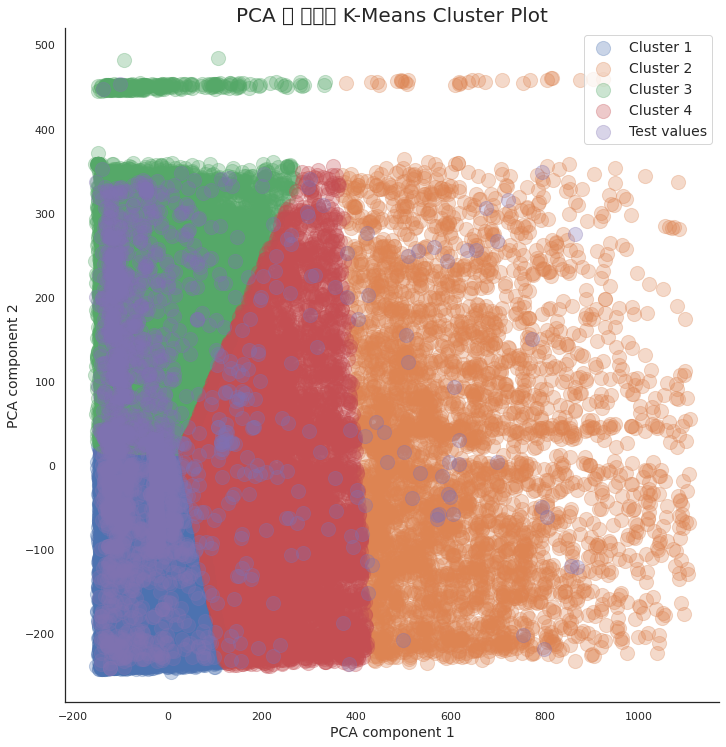

In [ ]:
orderhue= ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4','Test values']
sns.lmplot(x = 'PCA_1', y = 'PCA_2', data = df_PCA, fit_reg = False, legend = False, size = 10, hue = "cluster", hue_order= orderhue, scatter_kws={"s":200, "alpha":0.3} )
plt.xlabel('PCA component 1', fontsize = 14)
plt.ylabel('PCA component 2', fontsize = 14)
plt.title('PCA 를 이용한 K-Means Cluster Plot', fontsize = 20)
plt.legend(fontsize = 14)
plt.show()

##### T-SNE

In [ ]:
tsne = TSNE(n_components=2, perplexity=31, random_state=2020 )

In [ ]:
X_concat = df_clustered.values

In [ ]:
X_TSNE = tsne.fit_transform(X_concat)

In [ ]:
df_TSNE = pd.DataFrame.from_records(X_TSNE)
print(df_TSNE.shape)
df_TSNE.head()

(96770, 2)


,0,1
0,24.955603,-46.611927
1,19.824408,-49.840046
2,30.365652,-8.610099
3,39.207863,-44.624397
4,19.441607,-48.632492


In [ ]:
clust_series = pd.Series(clust)

In [ ]:
df_TSNE = df_TSNE.assign(cluster = clust_series)

print(df_TSNE.columns, df_TSNE.shape)
df_TSNE = df_TSNE.rename(columns={0: 'TSNE_1', 1: 'TSNE_2'})
df_TSNE["cluster"].replace({0: "Cluster 1", 1: "Cluster 2", 2: "Cluster 3", 3: "Cluster 4", 42: "Test values"}, inplace=True)
df_TSNE.head()

Index([0, 1, 'cluster'], dtype='object') (96770, 3)


,TSNE_1,TSNE_2,cluster
0,24.955603,-46.611927,Cluster 2
1,19.824408,-49.840046,Cluster 2
2,30.365652,-8.610099,Cluster 4
3,39.207863,-44.624397,Cluster 2
4,19.441607,-48.632492,Cluster 2


In [ ]:
df_TSNE["cluster"].value_counts()

Cluster 1      45544
Cluster 3      33796
Cluster 4      11478
Cluster 2       4016
Test values     1936
Name: cluster, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47484 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50857 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54620 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 47484 missing from current

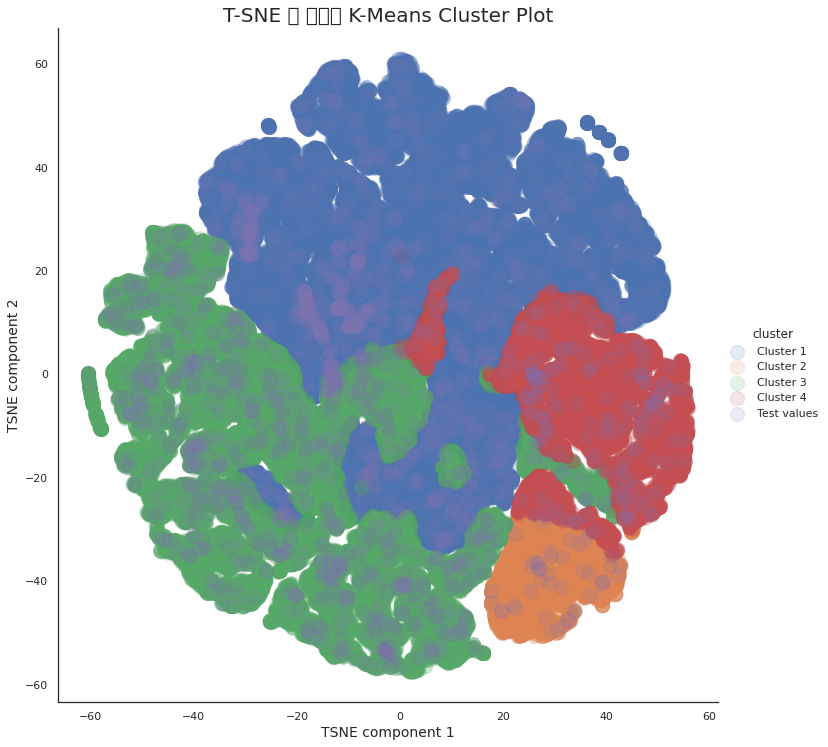

In [ ]:
orderhue= ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4','Test values']
sns.lmplot(x = 'TSNE_1', y = 'TSNE_2', data = df_TSNE, fit_reg = False, legend = True, size = 10, hue = "cluster", hue_order= orderhue, scatter_kws={"s":200, "alpha":0.15} )
plt.xlabel('TSNE component 1', fontsize = 14)
plt.ylabel('TSNE component 2', fontsize = 14)
plt.rc('font', family='NanumBarunGothic')
plt.title('T-SNE 를 이용한 K-Means Cluster Plot', fontsize = 20)
plt.show()

##### BoxPlot

In [ ]:
df_clustered_labeled = df_clustered.assign(cluster = clust_series)
df_clustered_labeled.head()

,0,1,2,3,4,cluster
0,8.0,992.96,93.84,5.0,288.0,1.0
1,6.0,1252.08,76.74,1.0,170.0,1.0
2,6.0,426.60,47.22,5.0,9.0,3.0
3,6.0,774.18,84.66,5.0,692.0,1.0
4,6.0,1157.04,61.24,5.0,112.0,1.0


In [ ]:
df_clustered_labeled.cluster.unique()

array([1., 3., 2., 0.])

In [ ]:
columnsvector = df_reduced.columns
print(columnsvector)
df_train_labeled = df_train
df_train_labeled.columns = columnsvector

Index(['amount_prod_categories', 'payment_value', 'freight_value',
       'review_score', 'recency'],
      dtype='object')


In [ ]:
df_train_labeled = df_train_labeled.assign(cluster = clusts_train)
df_train_labeled["cluster"].replace({0: "Cluster 1", 1: "Cluster 2", 2: "Cluster 3", 3: "Cluster 4"}, inplace=True)
df_train_labeled.head()

,amount_prod_categories,payment_value,freight_value,review_score,recency,cluster
0,8.0,992.96,93.84,5.0,288.0,Cluster 2
1,6.0,1252.08,76.74,1.0,170.0,Cluster 2
2,6.0,426.60,47.22,5.0,9.0,Cluster 4
3,6.0,774.18,84.66,5.0,692.0,Cluster 2
4,6.0,1157.04,61.24,5.0,112.0,Cluster 2


In [ ]:
x1 = df_train_labeled["cluster"]
y0 = df_train_labeled[df_train_labeled.columns[0]]
y1 = df_train_labeled[df_train_labeled.columns[1]]
y2 = df_train_labeled[df_train_labeled.columns[2]]
y3 = df_train_labeled[df_train_labeled.columns[3]]
y4 = df_train_labeled[df_train_labeled.columns[4]]

order = ["Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4"]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

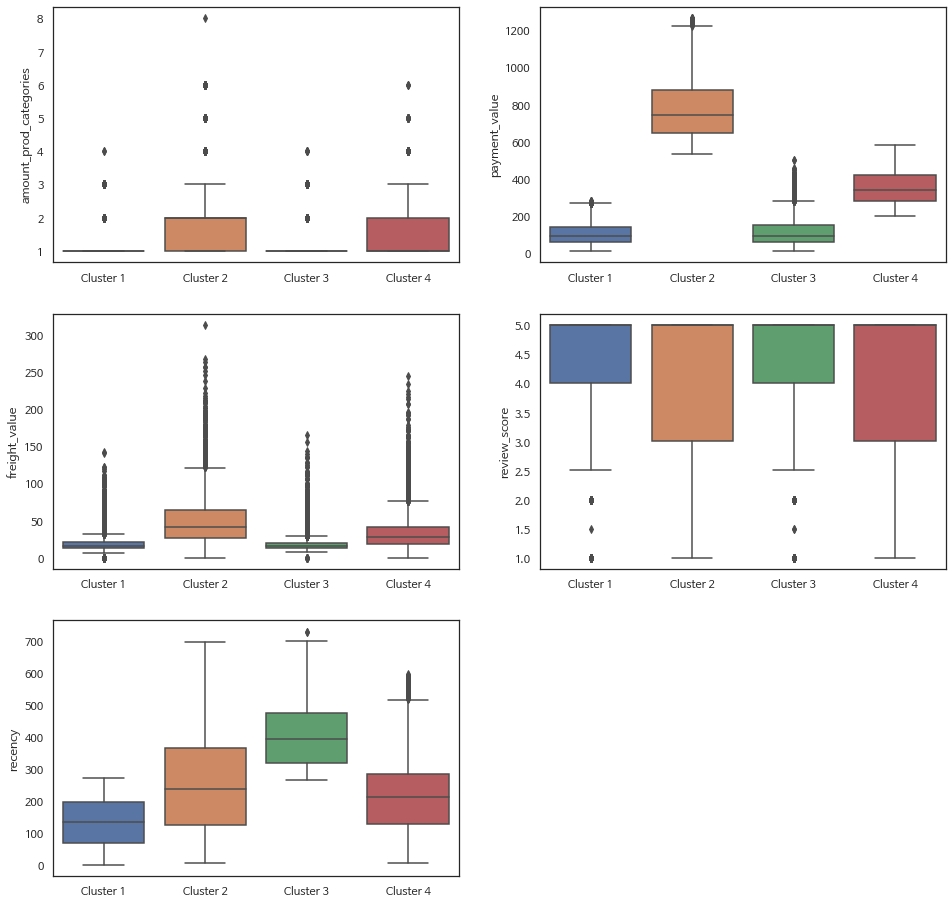

In [ ]:
plt.figure(figsize=(16,16))

plt.xlabel('')
plt.subplot(321)
plt.xticks([])

sns.boxplot(x1, y0,order= order, showfliers = True, data  = df_train_labeled)

plt.xlabel('')
plt.subplot(322)
plt.xticks([])

sns.boxplot(x1, y1,order= order, showfliers = True, data  = df_train_labeled)
plt.xlabel('')

plt.subplot(323)
plt.xticks([])


sns.boxplot(x1, y2,order= order, showfliers = True, data  = df_train_labeled)
plt.xlabel('')

plt.subplot(324)
sns.boxplot(x1, y3,order= order, showfliers = True, data  = df_train_labeled)

plt.xlabel('')

plt.subplot(325)
sns.boxplot(x1, y4,order= order, showfliers = True, data  = df_train_labeled)

plt.xlabel('')
plt.show()

#### 6) Cluster 간 분포

In [ ]:
km = KMeans(n_clusters=4, init="random", random_state=10)
clusts_test1 = km.fit_predict(X_test)

In [ ]:
df_test_labeled = df_test.assign(cluster = clusts_test1)
df_test_labeled["cluster"].replace({0: "Cluster 1", 1: "Cluster 2", 2: "Cluster 3", 3: "Cluster 4"}, inplace=True)
df_test_labeled.head()

,0,1,2,3,4,cluster
0,1.0,113.15,13.25,3.0,285.0,Cluster 3
1,1.0,315.54,16.54,5.0,11.0,Cluster 2
2,1.0,194.81,19.51,4.0,519.0,Cluster 1
3,1.0,56.78,7.78,5.0,264.0,Cluster 3
4,1.0,131.51,21.61,4.0,209.0,Cluster 3


In [ ]:
print (len(df_train_labeled["cluster"]))
(df_train_labeled["cluster"].value_counts()/len(df_train_labeled["cluster"]))*100

94834


Cluster 1    48.024970
Cluster 3    35.637008
Cluster 4    12.103254
Cluster 2     4.234768
Name: cluster, dtype: float64

In [ ]:
print (len(df_test_labeled["cluster"]))
(df_test_labeled["cluster"].value_counts()/len(df_test_labeled["cluster"]))*100

1936


Cluster 3    42.407025
Cluster 1    27.737603
Cluster 2    24.896694
Cluster 4     4.958678
Name: cluster, dtype: float64

### Clustering with DB-Scan

#### 1) 최적 파라미터 탐색

In [ ]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors


In [ ]:
eps_to_test = [0.01, 0.02]
min_samples_to_test = [10, 20, 75]
print("EPS VALUES:", eps_to_test)
print("MIN_SAMPLES:", min_samples_to_test)

EPS VALUES: [0.01, 0.02]
MIN_SAMPLES: [10, 20, 75]


In [ ]:
def get_metrics(eps, min_samples, dataset, iter_):
    dbscan_model_ = DBSCAN( eps = eps, min_samples = min_samples)
    dbscan_model_.fit(dataset)

    noise_indices = dbscan_model_.labels_ == -1
    
    if True in noise_indices:
        neighboors = NearestNeighbors(n_neighbors = 6).fit(dataset)
        distances, indices = neighboors.kneighbors(dataset)
        noise_distances = distances[noise_indices, 1:]
        noise_mean_distance = round(noise_distances.mean(), 3)
    else:
        noise_mean_distance = None
        
    number_of_clusters = len(set(dbscan_model_.labels_[dbscan_model_.labels_ >= 0]))
    
    print("%3d | Tested with eps = %3s and min_samples = %3s | %5s %4s" % (iter_, eps, min_samples, str(noise_mean_distance), number_of_clusters))
        
    return(noise_mean_distance, number_of_clusters)

In [ ]:
results_noise = pd.DataFrame( 
    data = np.zeros((len(eps_to_test),len(min_samples_to_test))),
    columns = min_samples_to_test, 
    index = eps_to_test
)

results_clusters = pd.DataFrame( 
    data = np.zeros((len(eps_to_test),len(min_samples_to_test))),
    columns = min_samples_to_test, 
    index = eps_to_test
)

In [ ]:
iter_ = 0

print("ITER| INFO%s |  DIST    CLUS" % (" "*39))
print("-"*65)

for eps in eps_to_test:
    for min_samples in min_samples_to_test:
        
        iter_ += 1
        
        noise_metric, cluster_metric = get_metrics(eps, min_samples, X_train, iter_)
        
        results_noise.loc[eps, min_samples] = noise_metric
        results_clusters.loc[eps, min_samples] = cluster_metric

ITER| INFO                                        |  DIST    CLUS
-----------------------------------------------------------------
  1 | Tested with eps = 0.01 and min_samples =  10 | 4.321    6
  2 | Tested with eps = 0.01 and min_samples =  20 | 4.318    0
  3 | Tested with eps = 0.01 and min_samples =  75 | 4.318    0
  4 | Tested with eps = 0.02 and min_samples =  10 | 4.321    6
  5 | Tested with eps = 0.02 and min_samples =  20 | 4.318    0
  6 | Tested with eps = 0.02 and min_samples =  75 | 4.318    0


#### 2) 최적 모델 기반 클러스터링

In [ ]:
eps = 0.01
min_samples_to_test = 11

dbscan_model = DBSCAN( eps = eps, min_samples = min_samples_to_test)
DBclusts_train = dbscan_model.fit(X_train)


In [ ]:
noise_metric, cluster_metric = get_metrics(eps, min_samples_to_test, X_train, 1)

  1 | Tested with eps = 0.01 and min_samples =  11 |  4.32    3


In [ ]:
DBclust = np.concatenate((DBclusts_train.labels_, clusts_test), axis=None)
print(clusts_test.shape ,DBclust.shape)
DBclust_series = pd.Series(DBclust)

(1936,) (96770,)


In [ ]:
dbtrainvector = DBclusts_train.labels_

#### 3) 시각화

##### PCA

In [ ]:
dfDB_PCA = df_PCA.assign(cluster = DBclust_series)
print(dfDB_PCA.columns, dfDB_PCA.shape)

Index(['PCA_1', 'PCA_2', 'cluster'], dtype='object') (96770, 3)


In [ ]:
dfDB_PCA['cluster'].value_counts()

-1.0     94796
 42.0     1936
 1.0        14
 2.0        12
 0.0        12
Name: cluster, dtype: int64

In [ ]:
dfDB_PCA = dfDB_PCA.dropna()
print(dfDB_PCA.columns, dfDB_PCA.shape)
dfDB_PCA['cluster'].unique()

Index(['PCA_1', 'PCA_2', 'cluster'], dtype='object') (96770, 3)


array([-1.,  0.,  1.,  2., 42.])

In [ ]:
dfDB_PCA["cluster"].replace({ -1: "Cluster 0"}, inplace=True)

In [ ]:
dfDB_PCA["cluster"].replace({0: "Cluster 1", 1: "Cluster 2", 2: "Cluster 3", 3: "Cluster 4", 4: "Cluster 5", 42: "Test values"}, inplace=True)
dfDB_PCA.head()

,PCA_1,PCA_2,cluster
0,832.699107,51.037656,Cluster 0
1,1091.605743,-64.378500,Cluster 0
2,267.318904,-233.303386,Cluster 0
3,609.901255,452.918387,Cluster 0
4,996.413936,-123.249609,Cluster 0


In [ ]:
dfDB_PCA['cluster'].value_counts()

Cluster 0      94796
Test values     1936
Cluster 2         14
Cluster 3         12
Cluster 1         12
Name: cluster, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


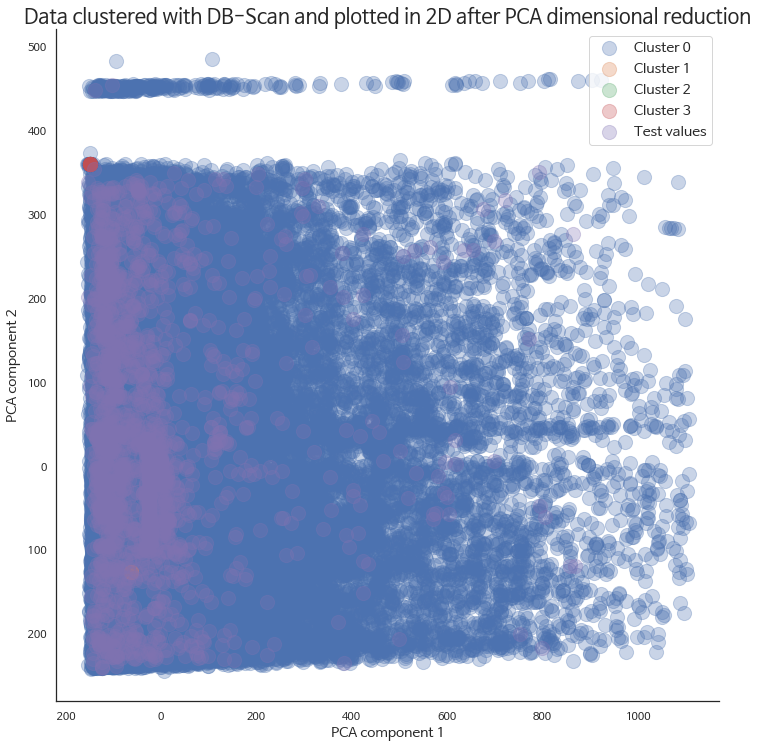

In [ ]:
db_orderhue= ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3',  'Test values']
sns.lmplot(x = 'PCA_1', y = 'PCA_2', data = dfDB_PCA, fit_reg = False, legend = False, size = 10, hue = "cluster", hue_order= db_orderhue, scatter_kws={"s":200, "alpha":0.3} )
plt.title('Data clustered with DB-Scan and plotted in 2D after PCA dimensional reduction' , fontsize = 20)
plt.xlabel('PCA component 1', fontsize = 14)
plt.ylabel('PCA component 2', fontsize = 14)
plt.legend(fontsize = 14)
plt.show()

In [ ]:
df_train_labeled = df_train_labeled.assign(dbcluster = dbtrainvector)
df_train_labeled["dbcluster"].replace({-1: "Cluster 1", 0: "Cluster 2", 1: "Cluster 3", 2: "Cluster 4"}, inplace=True)
print(df_train_labeled["dbcluster"].unique())
df_train_labeled.head()

['Cluster 1' 'Cluster 2' 'Cluster 3' 'Cluster 4']


,amount_prod_categories,payment_value,freight_value,review_score,recency,cluster,dbcluster
0,8.0,992.96,93.84,5.0,288.0,Cluster 2,Cluster 1
1,6.0,1252.08,76.74,1.0,170.0,Cluster 2,Cluster 1
2,6.0,426.60,47.22,5.0,9.0,Cluster 4,Cluster 1
3,6.0,774.18,84.66,5.0,692.0,Cluster 2,Cluster 1
4,6.0,1157.04,61.24,5.0,112.0,Cluster 2,Cluster 1


##### BoxPlot

In [ ]:
x2 = df_train_labeled["dbcluster"]
y0 = df_train_labeled[df_train_labeled.columns[0]]
y1 = df_train_labeled[df_train_labeled.columns[1]]
y2 = df_train_labeled[df_train_labeled.columns[2]]
y3 = df_train_labeled[df_train_labeled.columns[3]]
y4 = df_train_labeled[df_train_labeled.columns[4]]
order1 = ["Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4"]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

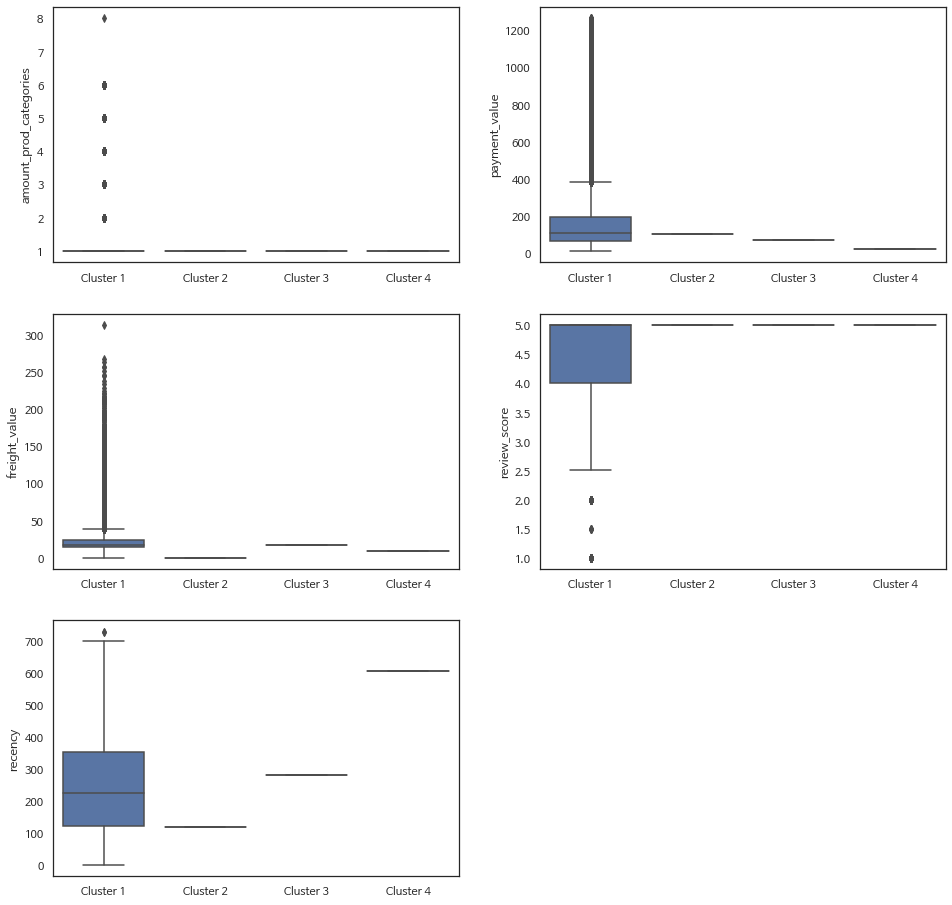

In [ ]:
plt.figure(figsize=(16,16))

plt.xlabel('')
plt.subplot(321)
plt.xticks([])

sns.boxplot(x2, y0,order= order, showfliers = True, data  = df_train_labeled)

plt.xlabel('')
plt.subplot(322)
plt.xticks([])

sns.boxplot(x2, y1,order= order, showfliers = True, data  = df_train_labeled)
plt.xlabel('')

plt.subplot(323)
plt.xticks([])


sns.boxplot(x2, y2,order= order, showfliers = True, data  = df_train_labeled)
plt.xlabel('')

plt.subplot(324)
sns.boxplot(x2, y3,order= order, showfliers = True, data  = df_train_labeled)

plt.xlabel('')

plt.subplot(325)
sns.boxplot(x2, y4,order= order, showfliers = True, data  = df_train_labeled)

plt.xlabel('')
plt.show()